# Brain tumor segmentation using U-Net


## Introduction

In this code, we apply image processing method using a deep learning model to identify the brain tumors and divide them into sub-regions by classifying each pixel in each image. This technique is called **image segmentation**.


We will follow these instructions:

- Step 1 - Set up Environment
- Step 2 - Download the Dataset
- Step 3 - Data Exploration
- Step 4 - Prepare Data for Training
- Step 5 - Define the Model
- Step 6 - Train the Model
- Step 7 - Predict from the Model


This code is inspired from [Rastislav](https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net) and [Mathieu Busquet](https://github.com/ovh/ai-training-examples/blob/main/notebooks/computer-vision/image-segmentation/tensorflow/brain-tumor-segmentation-unet/notebook_image_segmentation_unet.ipynb) with slightly changes.

### Step 1 - Set up Environment
We are running our code in [Colab](https://colab.google/) which is helpful for modeling large image dataset. The following code  mounts Google Drive into the Colab environment.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

For running the code in a local computer, we first need to go through [README](https://github.com/biedun/Brain-Tumor-Segmentation-JEPSis/blob/main/README.md), create a virtual environment, adapt to a suitable version of Python and install all required libraries listed in the requirements.txt file, which can slightly vary for different OSs. As aLinux user, I go through the following steps:

In [ ]:
#pyenv local 3.11.3
#python -m venv .venv
#source .venv/bin/activate
#pip install --upgrade pip
#pip install -r requirements.txt

Now we import all the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import zipfile
import nibabel as nib
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, concatenate, Input, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

2024-05-24 09:00:48.877311: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 09:00:49.155028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 09:00:49.155128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 09:00:49.199107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 09:00:49.294220: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 09:00:49.295110: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Step 2 - Download the Dataset
The dataset is available at this [website](https://www.kaggle.com/datasets/andrewmvd/brain-tumor-segmentation-in-mri-brats-2015/data). There are three different folders containing the data for years 2018, 2019 and 2020. At first glance, it seems that these folders contain the updated information of the patiants by year that would have been more exciting to check the Tumor evolusions. However, there is no such update and the only difference among these folders is the most recent folder (2020) has more patians. Therefore, we only concentrate in BraTS20 dataset, belongs 2020.

Using the following code, we unzip the file:    

In [ ]:
# Unzip dataset
path_to_zip_file = "/home/somayyeh/Desktop/BraTS20data/MICCAI_BraTS2020_TrainingData.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("/home/somayyeh/Desktop/BraTS20data")

One of the files has a diffrent name than the others. So first we rename it in a way that we have coherent names for all files:

In [ ]:
# Absolute path of the incorrectly named file
#old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
#new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming the file
#try:
    #os.rename(old_name, new_name)
   # print("The file has been successfully renamed")
#except FileNotFoundError:
   # print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

### Step 3 - Data Exploration
Data on Brain Tumor Segmentation 2020 **(BraTS20)** has been published by the National Cancer Institute (NCI). They are 3D images of magnetic resonance imaging ***(MRI)*** scancs for 369 patiants diagnosed for Glioma tumor, each saved in a seperate folder. Each folder contains 4 different types of  MRI scans known as **modalities** (each as our feature). In addition, we also have another image specifying different segments of the tumor (as our label), recognised by the radiologists. Having access to both features and labels in this project, we deal with a **supervised learning** and our goal is to analyze the MRI images and segment the tumor into its different components.

These 3D MRI scans are provided as the MRI device scans the brain from back-to-front, left-to-right or belwo-to-top. The result will be many 2D images, called **slices**.

Modalities are named T1,T1ce,T2 and FLAIR which each of them exhibit different aspects of the brain:

• **T1** : Show the structure and composition of different types of tissue.\
• **T1CE**: Similar to T1 images but with the injection of a contrast agent, which will enhance the visibility of abnormalities.\
• **T2**: Show the fluid content of different types of tissue.\
• **FLAIR**: Used to suppress this fluid content, to better identify lesions and tumors that are not clearly visible on T1 or T2 images.

The radiologists usually need to use all four imaging modalities to distingush accurately a tumor and confirming its presence. However, for our computation we only need two modalities—rather than four, since it makes the process quicker and less demanding on computer resources. Therefore, we will not use the T1 modality as **T1ce** is an enhanced version of it. We will also exclude T2 because the fluids that it shows might interfere with our predictions. The **FLAIR** modality, which removes these fluids and better highlights affected areas, will be more useful for our training.

These images are in the format of **NifTI** (Neuroimaging Informatics Technology Initiative) that is seen as **.nii** at the end of each image file.

The following code exhibits four different modalities along with segmentation image of the first patient for the 70th slice as an example.

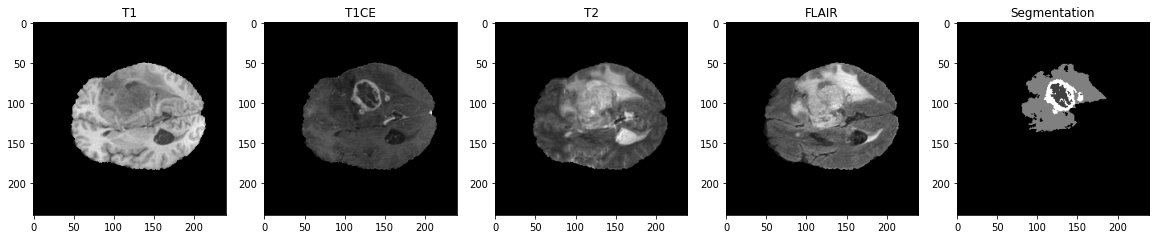

In [2]:
# Specify a sample path 
sample_path = '/home/somayyeh/Desktop/BraTS20data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_sample_img=nib.load(sample_path + 't1.nii')
t1ce_sample_img=nib.load(sample_path + 't1ce.nii')
t2_sample_img=nib.load(sample_path + 't2.nii')
flair_sample_img=nib.load(sample_path + 'flair.nii')
sample_mask=nib.load(sample_path + 'seg.nii')

# Convertthe image file into a floating-point numpy array
t1_data = t1_sample_img.get_fdata()
t1ce_data = t1ce_sample_img.get_fdata()
t2_data = t2_sample_img.get_fdata()
flair_data = flair_sample_img.get_fdata()
mask_data = sample_mask.get_fdata()

# Plot the 70th slice of the 4 RMI modalities and the segmentation
slice_nb = 70

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(mask_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

Each .nii file is 155 slices of 2D images with the pixel size of 240 x 240:

In [72]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(mask_data.shape)

(240, 240, 155)
(240, 240, 155)


The advantage of 3D form .nii format is that we can have a look at the brain images from the three different directions. In medical imaging, they are named **axial/transverse**, **coronal**, and **sagittal** planes.

- **Sagittal Plane**: It is a vertical plane that divides the body or an organ into left and right parts and is often used to view structures from a "side-side" view.

- **Coronal Plane**: It  divides the body or an organ into front (anterior) and back (posterior) parts and often used to view structures from a "front-back perspective".

- **Axial or Transverse Plane**: It divides the body or an organ into upper and lower parts and is often used to view structures from a "top-down" perspective.

So of course we can display each modality through its different planes. For example, we will display the 3 planes of the T1 image:

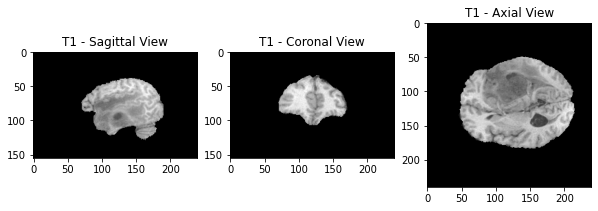

In [73]:
# Plot a MRI modality through all planes

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

As earlier mentioned, each modalitiy has 155 slices. In the following code, we represent all slices of flair modality at once. 

(2480, 3840)


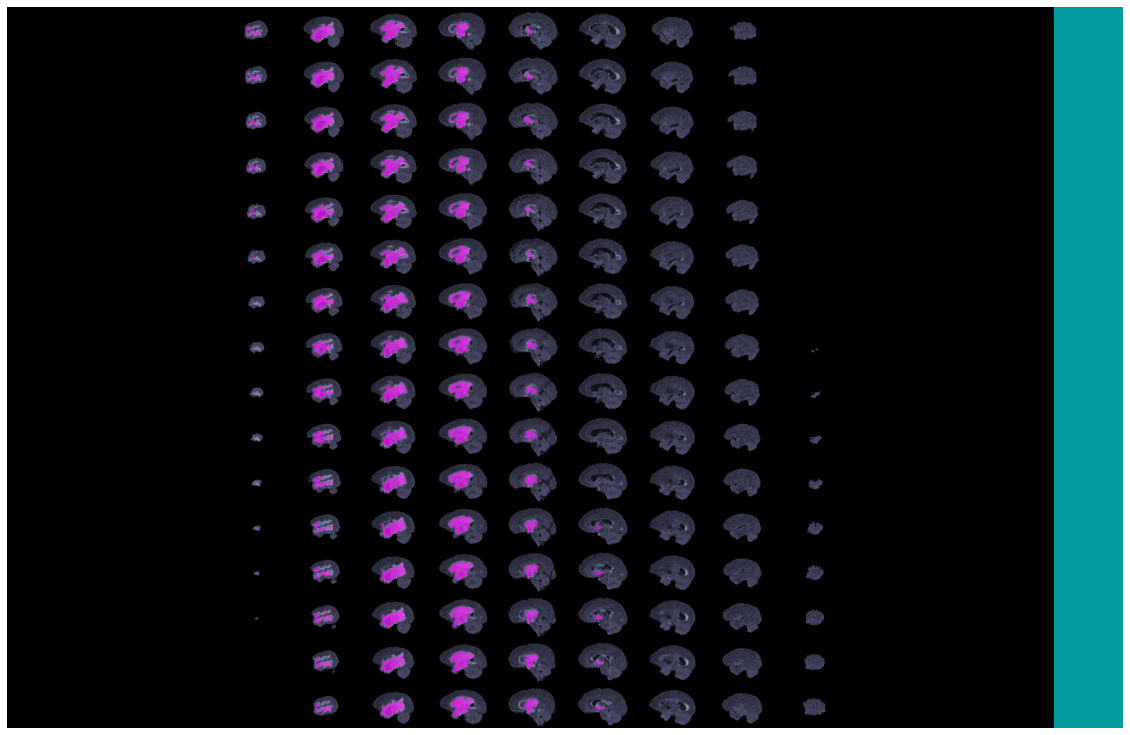

In [74]:
# take the flair modality
flair_path = sample_path +'flair.nii'


# rotate the imsges for better view
image = np.rot90(montage(flair_data))
mask = np.rot90(montage(mask_data))
mask = np.clip(mask, 0, 1)
label = flair_path.replace('/', '.').split('.')[-2]

print(image.shape)

#plot image and mask together
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(image, cmap ='bone')
ax1.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6, animated=True)


ax1.set_facecolor('black')
ax1.axis('off')
fig.savefig(f'{label}_3d_to_2d.png', format='png', bbox_inches='tight')

The black parts on the left and right sides in above picture correspond to initial and final slices where these slices do not contain much information. So here, as well as in our modeling part, we exclude these slices and concentrate only on 75 middle slices (from 60 to 135 sclices) to avoid unnecessary computation.

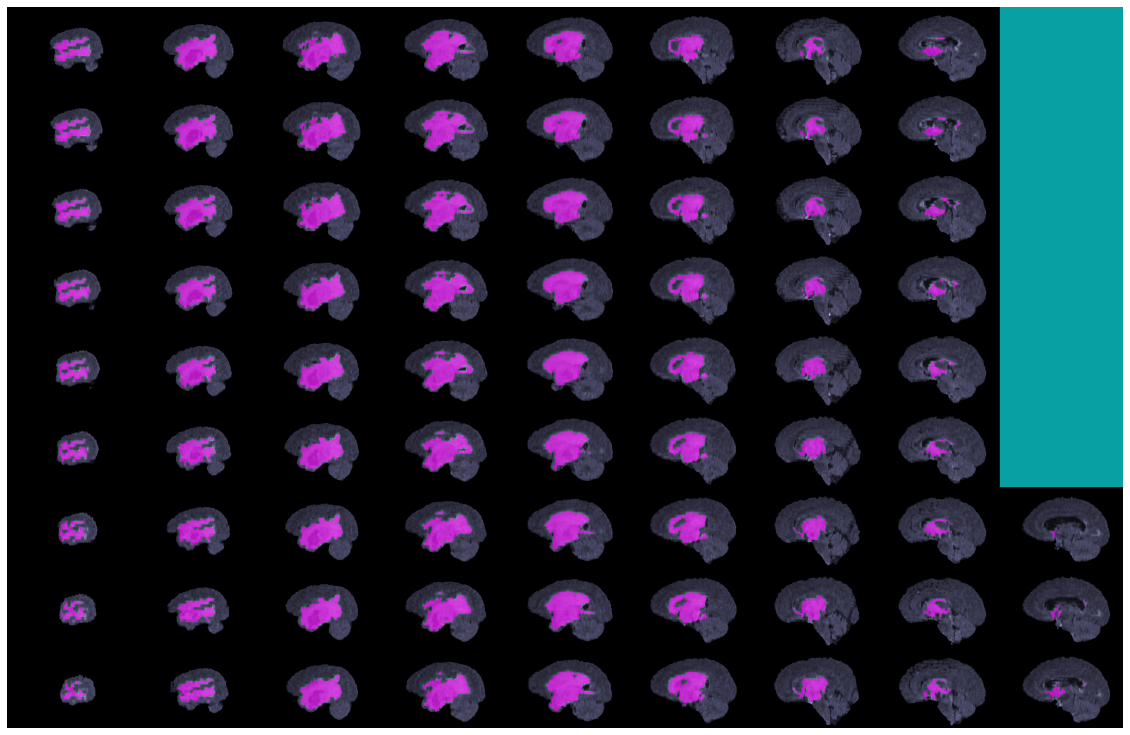

In [75]:
# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

# rotate the imsges for better view
image = np.rot90(montage(flair_data[VOLUME_START_AT:VOLUME_START_AT+VOLUME_SLICES,:,:]))
mask = np.rot90(montage(mask_data[VOLUME_START_AT:VOLUME_START_AT+VOLUME_SLICES,:,:]))
mask = np.clip(mask, 0, 1)

#plot image and mask together
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(image, cmap ='bone')
ax1.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6, animated=True)


ax1.set_facecolor('black')
ax1.axis('off')
fig.savefig(f'{label}_3d_to_2d.png', format='png', bbox_inches='tight')

The colored areas in two above figures is a map of semented image (mask/lable) on the image.

Looking at the segmented image recognised by the radiologist (the following figure), we realize four different sub-regions:


- **No Tumor (NT)**: This area is the healthy part of the brain.
- **Necrotic and Non-Enhancing Tumor (NCR +NET)** This region represents areas where tumor cells have died.
- **Edema (ED)**: This region refers to the swelling of brain tissues surrounding the tumor.
- **Enhancing Tumor (ET)**: Enhanced region is indicative of active tumor growth and is often associated with high-grade malignancies.




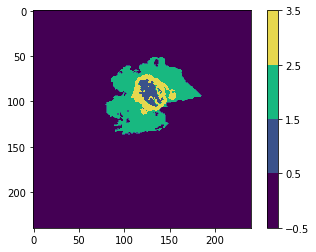

In [76]:
# Plot a segmantation

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(mask_data[:,:, slice_nb], cmap=cmap, norm=norm)
plt.colorbar()

### Step 4 - Prepare Data for Training

Now we start with taking the directory of all 369 patients. 

In [2]:
# Specify path of our BraTS2020 directory
data_path = "/home/somayyeh/Desktop/BraTS20data/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)

# remove the other folder(s) from the sample variable 
samples.remove("saved_data")
print("Number of samples:", len(samples))

Number of samples: 369


In case there is a mismatch between the number of image lists (t1ce_list and flair_list) and label list (mask_list) due to a variation in the naming of mask files in one of the folders, the following code is to identify this inconsistency. Once detected, we manually adjust it to have uniformity across folders.

In [3]:
"""

folders = os.listdir(data_path)  # List all folders
folders.sort()  # Optional, but helps in maintaining order for easy checking

missing_masks = []

# Check each folder for the existence of the mask file
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    # Construct the mask filename based on the folder name
    mask_filename = f"{folder}_seg.nii"
    mask_path = os.path.join(folder_path, mask_filename)
    if not os.path.isfile(mask_path):
        missing_masks.append(folder)

if missing_masks:
    print("Folders missing mask files:", missing_masks)
else:
    print("All folders have mask files.")"""



'\n\nfolders = os.listdir(data_path)  # List all folders\nfolders.sort()  # Optional, but helps in maintaining order for easy checking\n\nmissing_masks = []\n\n# Check each folder for the existence of the mask file\nfor folder in folders:\n    folder_path = os.path.join(data_path, folder)\n    # Construct the mask filename based on the folder name\n    mask_filename = f"{folder}_seg.nii"\n    mask_path = os.path.join(folder_path, mask_filename)\n    if not os.path.isfile(mask_path):\n        missing_masks.append(folder)\n\nif missing_masks:\n    print("Folders missing mask files:", missing_masks)\nelse:\n    print("All folders have mask files.")'

To ensure about the number of tumor sub-regions, the following code checks the class of different subregions in all masks. 

In [3]:
#go through all folders and take the mask file
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in samples] 

saved_values = []

max_nb_values = 0

# check the class of each file
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))
    
    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


The sub-regions have been classified as follows:

- 0 : NT,
- 1 : NCR + NET
- 2 : ED
- 4 : ET

As you can see, classification is not in order and class 4 exist rather than class 3. Later, we will modify this and set the classes in order.

Here, we split our dataset into three groups as **train** , **test** and **validation** sets:

In [4]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.1, random_state=42)

# Split the train set into the real train set and in a test set 
samples_train, samples_test = train_test_split(samples_train, test_size=0.2, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 265
Validation length: 37
Test length: 67


In the last step of preparing data for training, we use the following data generator class to load data in small batches to the model in order to prevant memory issues due to having big data. Furthermore, we reduce the size of slices in order to have doable calculations in the local computers. As mentioned before, we only keep 75 middle slices.

The DataGenerator class contains the following steps:
* **init function** initializes the data generator with specified parameters such as image dimensions, batch size, list of patient IDs, number of channels, and whether to shuffle the data. It also calls on_epoch_end() to set up initial indexes.
* **len function** returns the number of batches per epoch.
* **getitem function** generates one batch of data and generates the data using __data_generation.
* **on_epoch_end function** updates the indexes after each epoch and shuffles the indexes to ensure the data is mixed for the next epoch.
* **data_generation function** generates the data for a batch of patient IDs.


In data_generation function,which is the most important part of the class, the .nii format of the images and masks are converted into numpy arrays. The data of two required modality, where are 3 dimnesional images, are stored into a 4 dimensional single NumPy array with two channles so that each modality is storded in each channel and consequently the final shape of single array is as (number_of_sclices, reduced_image_size, reduced_image_size, number_of_channels) for images. For label images (masks) we create another 4 dimensional sinlge array with 4 channels where each channel stores one-hotted 4 different classes (sub-regions of tumor), therefore, the final shape of this 4 dimensional array for masks is (number_of_sclices, reduced_image_size, reduced_image_size, number_of_classes). As you see each channel of the mask after aplying one-hot is either 0 or 1.


In [5]:
IMG_SIZE = 240
VOLUME_START_AT = 60
VOLUME_SLICES = 75 
    
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))


            
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):
            
            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path +'_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'
            
    
    
            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    
        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X, Y
    

        
training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

The following code confirms the shape of X and y arrays, after applying DataGenerator class to them. As expected, y after one-hotting, has only two values of 0 and 1. 

In [6]:
# Assuming training_generator is an instance of DataGenerator
X, y = training_generator[0]
values, counts = np.unique(y, return_counts=True)

print("Input batch shape:", X.shape)
print("Labels batch shape:", y.shape)
print("Unique label values:", values)


2024-05-23 17:26:14.045679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:26:14.047307: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-23 17:26:14.171173: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34560000 exceeds 10% of free system memory.
2024-05-23 17:26:14.209564: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69120000 exceeds 10% 

Input batch shape: (75, 240, 240, 2)
Labels batch shape: (75, 240, 240, 4)
Unique label values: [0. 1.]


### Step 5 - Define the model

Here we are going to use the U-Net architechture that is a common Convolutional Neural Network (CNN) for image segmentation. The following code is the [U-Net implementation](https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a) written by Naomi Fridman for BraTS-2019. For more information on U-net structure, one can be refered to a bublished [paper](https://arxiv.org/abs/1505.04597).

In [7]:
# U-Net implementation
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

#### Evaluation Metrics:

To monitor the model's performance we use the following evaluation metrics:
- **Dice coefficient**
- **intersection over union (IoU) score**

For the last two metrics, we use the deifned ones in the segmentation_models package and for the dice coefficient, a funcrion can be defined.


In [8]:
#defining the Dice score
def dice_coefficient(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


all_metrics = [dice_coefficient, tensorflow.keras.metrics.MeanIoU(num_classes=4)]

### Step 6 - Train the Model
Applying the model, compiling it and fitting it to our numpy array set:

In [ ]:
#DO NOT RUN IF MODEL AVAILABLE!!!

# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = all_metrics ) # loss = "categorical_crossentropy"

# callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
    
    keras.callbacks.ModelCheckpoint(filepath = 'saved_data/model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

# Fit the model
model.fit(training_generator,
          epochs=35,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)
# Save the model 
model.save(data_path + '/saved_data/saved_models/model_{timestr}.keras')



Epoch 1/35


2024-05-22 16:41:44.009269: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.
2024-05-22 16:41:44.234627: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.
2024-05-22 16:41:44.684310: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.
2024-05-22 16:41:44.849298: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.
2024-05-22 16:41:47.538547: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.


 25/265 [=>............................] - ETA: 5:28:15 - loss: 121.1877 - dice_coefficient: 0.2112 - mean_io_u: 0.3750

### Metrics analysis
This code plots the evaluation metrics during 35 epochs and gives us an overview of their improvment.

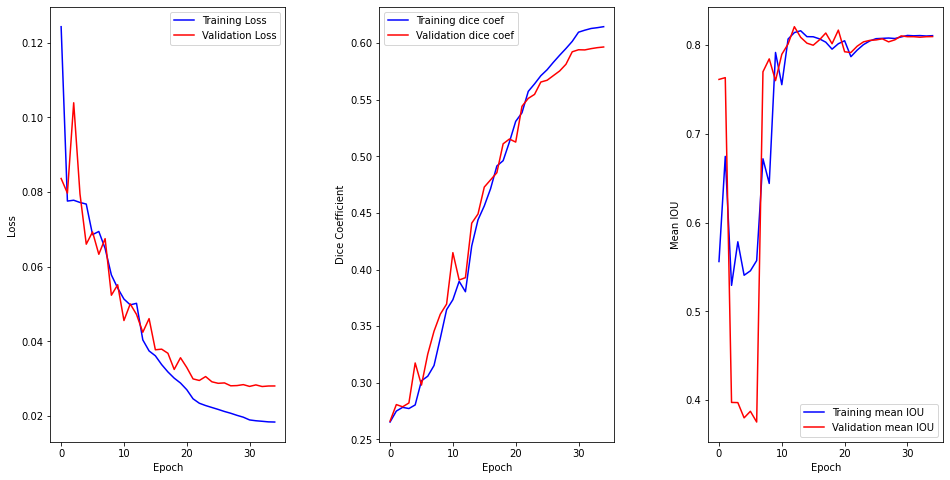

In [10]:
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv(data_path + '/saved_data/saved_models/training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 3, figsize=(16, 8))


axs[0].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[0].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[1].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Dice Coefficient')
axs[1].legend()

axs[2].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
axs[2].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Mean IOU')
axs[2].legend()


# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

Here, we observe that our model is effectively learning from the training data, as is seen by the decreasing losses over tim. Additionally, The optimal version of our model is achieved around epoch 26. 

### Step 7 - Predict from the Model

Now we can use the trained model to predict the tumor segmentation.
The following function aims to get the path of data for one of the patients and apply prediction of our model.

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X, verbose=1)

We need another function that goes through our test data, called samples_test after splting the data, and chooses a random patient's data and predicts the segmentation for their tumor.

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

#### Plot Random predictions & Compare with Original (Ground truth)

3/3 [==============================] - 41s 12s/step
Patient number:  BraTS20_Training_105


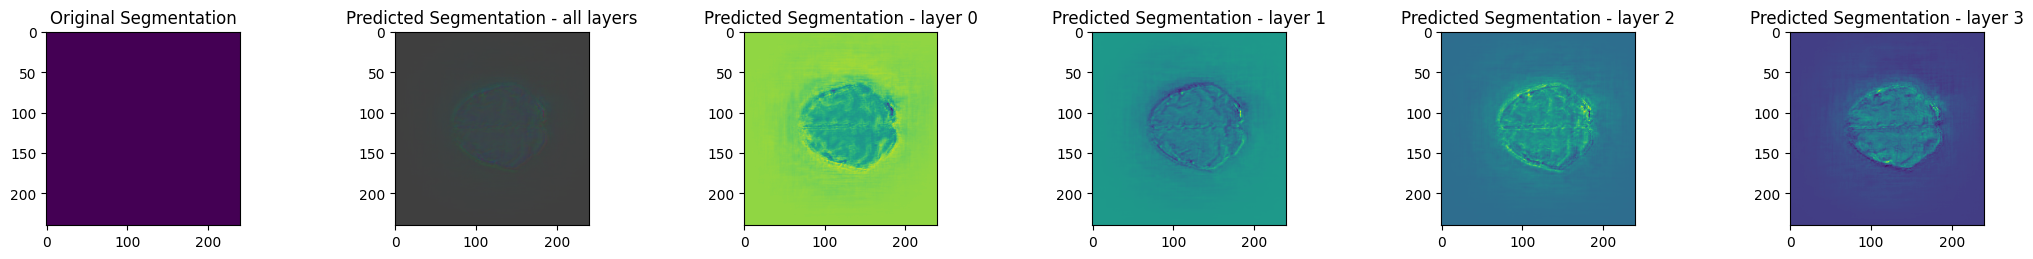

In [ ]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

3/3 [==============================] - 0s 71ms/step
Patient number:  Brats18_2013_0_1


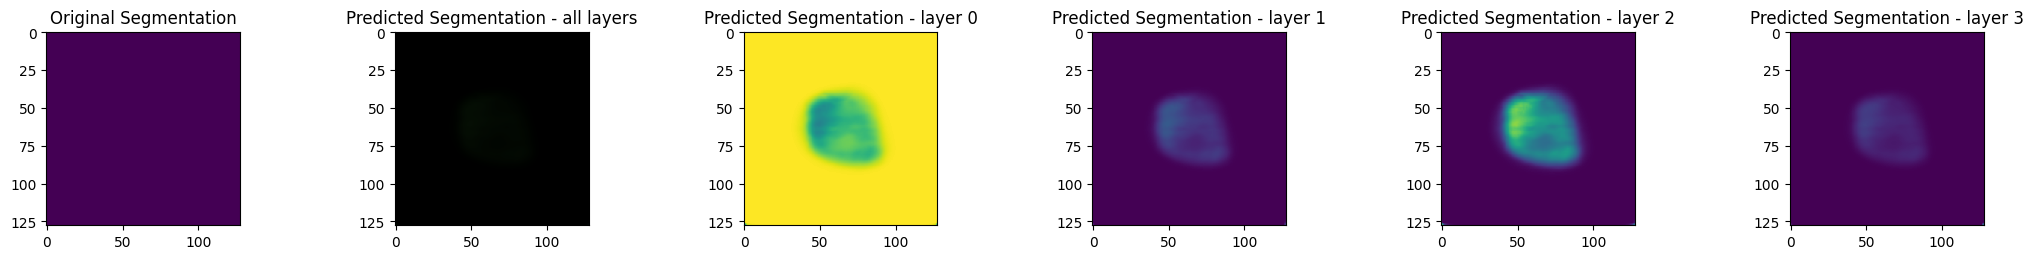

In [ ]:
show_predicted_segmentations(samples_test, 50, cmap, norm)

3/3 [==============================] - 0s 71ms/step
Patient number:  Brats18_2013_12_1


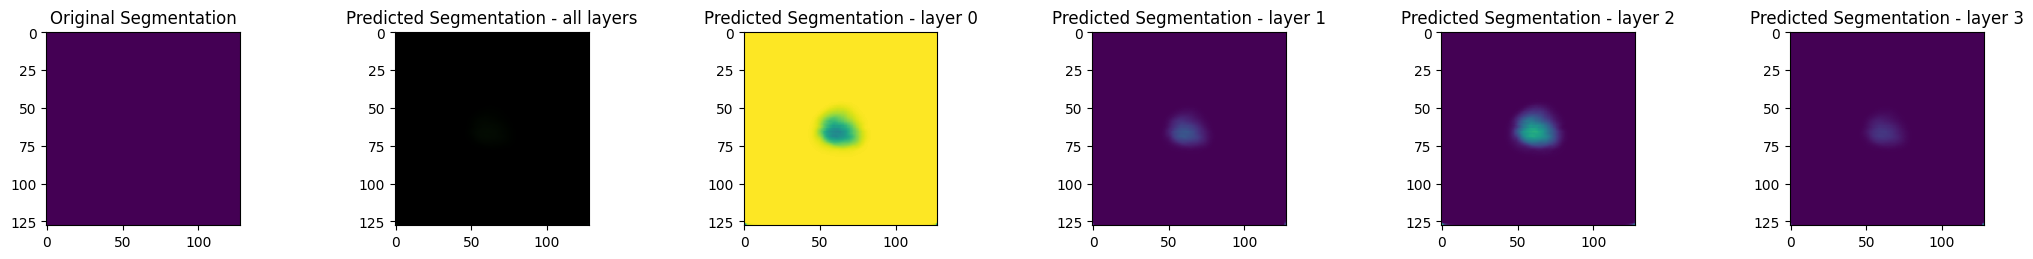

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

3/3 [==============================] - 0s 73ms/step
Patient number:  Brats18_2013_15_1


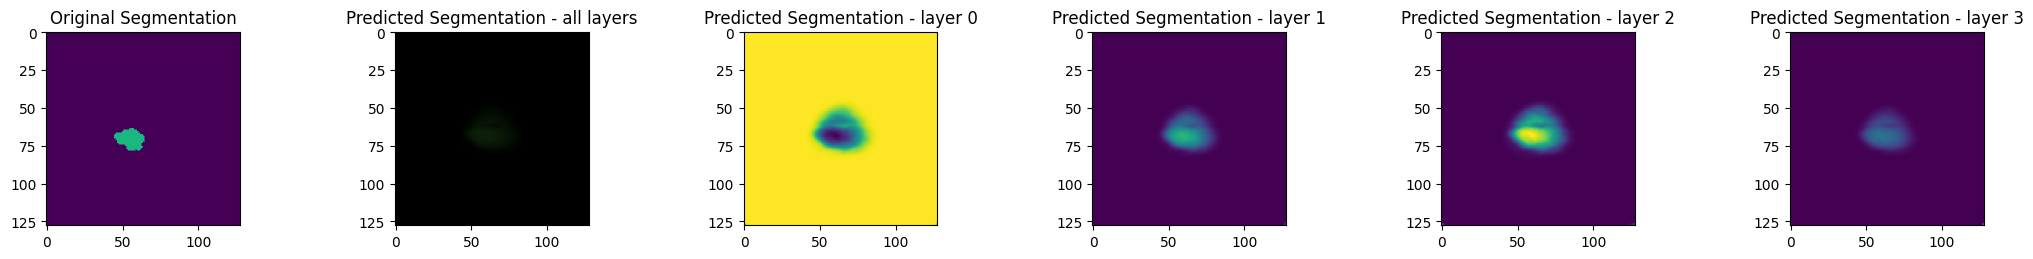

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

3/3 [==============================] - 0s 70ms/step
Patient number:  Brats18_2013_12_1


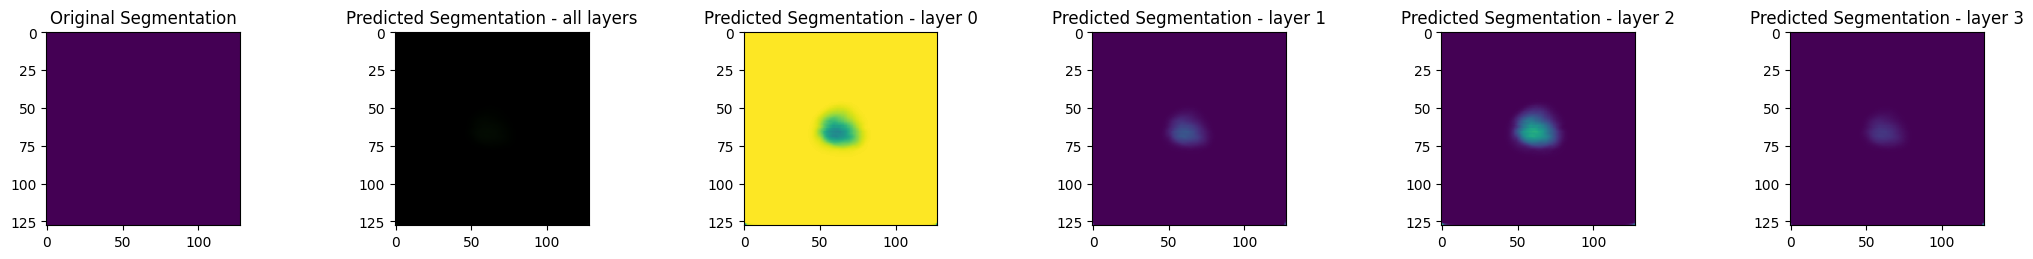

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

As you can see, predicted segmentations are quite accurate.